# XLNET

In [1]:
!pip install -q -U watermark

In [6]:
!pip install torch

In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

numpy       : 1.26.4
pandas      : 1.4.4
torch       : 2.2.0
transformers: 4.37.2



In [23]:
import transformers
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup
import torch

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

C:\Users\Yuktha\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
from torch import nn,optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [26]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
df=pd.read_csv(r"C:\Users\Yuktha\Desktop\Internship details\IMDB Dataset.csv")

In [28]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [29]:
from sklearn.utils import shuffle
df=shuffle(df)
df.head()

,review,sentiment
304,"This is definitely a ""must see"" film. The exce...",positive
33751,It's a bit difficult to believe that this came...,negative
12684,"Diane Lane is beautiful and sexy, and Tuscany ...",negative
48905,"I recently stumbled across a TV showing of ""Pa...",positive
3673,This is a stupid movie. Like a lot of these ka...,negative


In [30]:
df=df[:24000]
len(df)

24000

In [31]:
import re
def clean_text(text):
    text=re.sub(r"@[A-Za-z0-9]+", '', text)
    text=re.sub(r"https?://[A-Za-z0-9./]+",'',text)
    text=re.sub(r"[^a-zA-z.!?'0-9]", '', text)
    text=re.sub('/t','',text)
    text=re.sub(r" +", '', text)
    return text

In [32]:
df['review']=df['review'].apply(clean_text)

C:\Users\Yuktha\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'review score')

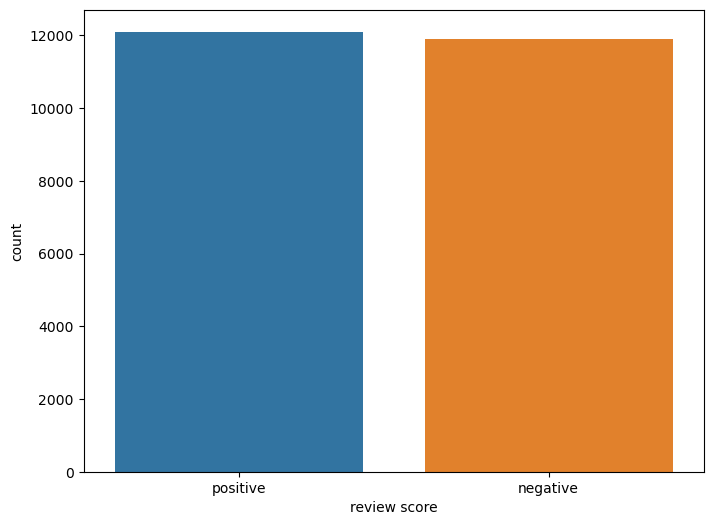

In [33]:
rcParams['figure.figsize']=8,6
sns.countplot(df.sentiment)
plt.xlabel('review score')

In [34]:
def sentiment2label(sentiment):
    if sentiment=="positive":
        return 1
    else:
        return 0
df['sentiment']=df['sentiment'].apply(sentiment2label)

In [35]:
df['sentiment'].value_counts()

1    12100
0    11900
Name: sentiment, dtype: int64

In [36]:
class_names=['negative','positive']

# XLNET TOKENIZER

In [37]:
!pip install SentencePiece

In [38]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [39]:
from transformers import XLNetTokenizer,XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer=XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [40]:
input_txt="India is my country. All Indians are my brothers and sisters"
encodings=tokenizer.encode_plus(input_txt,add_special_tokens=True, max_length=16, return_tensors='pt', return_tokens=tokenizer.encode("India is my country. All Indians are my brothers and sisters"), truncation=True)

Keyword arguments {'return_tokens': [837, 27, 94, 234, 9, 394, 7056, 41, 94, 4194, 21, 8301, 4, 3]} not recognized.


In [41]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [42]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [43]:
type(encodings['attention_mask'])

torch.Tensor

In [45]:
attention_mask=pad_sequences(encodings['attention_mask'],maxlen=512,dtype=torch.Tensor,truncating="post",padding="post")

In [47]:
attention_mask=attention_mask.astype(dtype='int64')
attention_mask=torch.tensor(attention_mask)
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
encodings['input_ids']

tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

In [55]:
token_lens=[]
for txt in df['review']:
    tokens=tokenizer.encode(txt,max_length=512)
    token_lens.append(len(tokens))

C:\Users\Yuktha\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


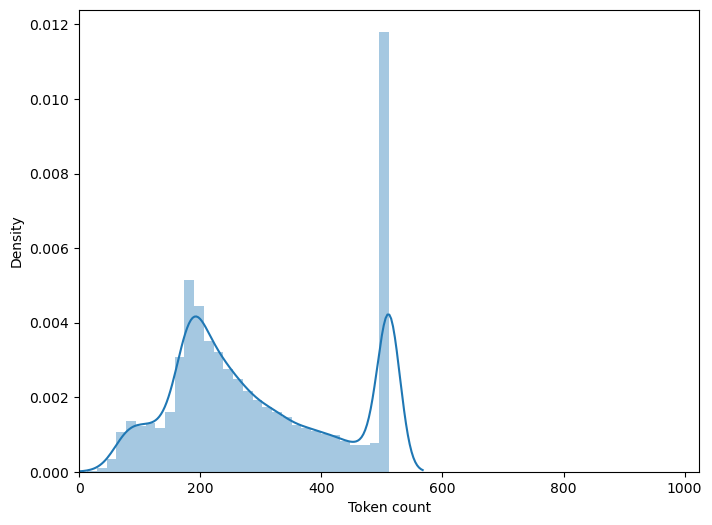

In [58]:
sns.distplot(token_lens)
plt.xlim([0,1024]);
plt.xlabel('Token count');

In [59]:
MAX_LEN=512